In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, f_classif

from funs import plotDictionary, chi2_independence, highlightTable

# Data Preprocessing

## Data Collection

### Raw Data

In [2]:
all_trxns = pd.read_csv("../data/all_trxns.csv", dtype={"counterparty": str})

### Exchange Rates
more info in `Currencies.ipynb`


In [3]:
currency_rates = pd.read_csv(
    "../data/exchange_rates.csv", header=None, names=["ccy", "date", "rate"]
)

## Cleaning and Transformation
Get as many factors as possible
Transform the variables and provide additional features
1. Convert the timestamp to datetime
2. Add the date and the exchange rate
3. Clean and convert the amount to EUR
4. Extract the customer type from the customer id
5. Extract the weekday, month, quarter and hour from the timestamp
6. Replace missing values in the "counterparty_country" column with "unknown"
7. Add "amount_eur" buckets - calculate the thresholds for the equally sized buckets of the amount in EUR

In [4]:
trxns_data = all_trxns.copy()

trxns_data["timestamp"] = pd.to_datetime(
    trxns_data["timestamp"], infer_datetime_format=True
)

trxns_data["date"] = trxns_data["timestamp"].dt.date
trxns_data = trxns_data.merge(currency_rates, on=["ccy", "date"], how="left")
trxns_data["rate"] = np.where(trxns_data["rate"].isna(), 1, trxns_data["rate"])

trxns_data["amount"] = trxns_data["amount"].apply(
    lambda x: float(re.sub("[^0-9.]", "", x))
)
trxns_data["amount_eur"] = trxns_data["amount"] / trxns_data["rate"]

trxns_data["customer_type"] = trxns_data["customer"].str[0]

trxns_data["weekday"] = trxns_data["date"].apply(lambda x: x.strftime("%A"))
trxns_data["month"] = trxns_data["date"].apply(lambda x: x.strftime("%B"))
trxns_data["quarter"] = trxns_data["date"].apply(
    lambda x: "Q" + str((x.month - 1) // 3 + 1)
)
trxns_data["hour"] = trxns_data["timestamp"].dt.hour
#
trxns_data["counterparty_country"] = np.where(
    trxns_data["counterparty_country"].isna(),
    "unknown",
    trxns_data["counterparty_country"],
)

amount_eur_quantile = np.quantile(trxns_data["amount_eur"], q=np.arange(0, 1.2, 0.2))

trxns_data["amount_eur_bucket"] = pd.cut(
    trxns_data["amount_eur"], bins=amount_eur_quantile, include_lowest=True
)

C:\Users\mateu\AppData\Local\Temp\ipykernel_15064\455284875.py:3: UserWarning: The argument 'infer_datetime_format' is deprecated and will be removed in a future version. A strict version of it is now the default, see https://pandas.pydata.org/pdeps/0004-consistent-to-datetime-parsing.html. You can safely remove this argument.
  trxns_data["timestamp"] = pd.to_datetime(


In [5]:
print(trxns_data)

             customer customer_country fraud_flag           timestamp  \
0     C12976926337644               UK          N 2021-03-20 05:59:25   
1     C12976926337644               UK          N 2021-05-02 03:00:38   
2     C12976926337644               UK          N 2021-05-23 22:15:15   
3     C12976926337644               UK          N 2021-07-07 21:36:50   
4     C12976926337644               UK          N 2021-09-02 00:14:03   
...               ...              ...        ...                 ...   
5297  R85394663171656               UK          N 2021-12-20 00:34:56   
5298  R85394663171656               UK          N 2021-12-23 17:49:44   
5299  R85394663171656               UK          N 2021-01-18 15:14:34   
5300  R85394663171656               UK          N 2021-04-03 00:13:03   
5301  R85394663171656               UK          N 2021-09-03 18:32:38   

        counterparty counterparty_country      type  ccy     amount  \
0     77697395249488                   CN     OTHER 

# Data Analysis

## Number of Frauds
1. Prepare plot data
2. Plot the data
3. Add the percentage on top of the bars

C:\Users\mateu\AppData\Local\Temp\ipykernel_15064\31235224.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_data["count"] = 1


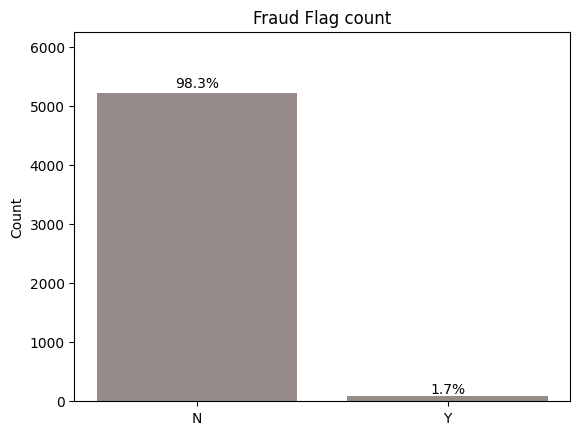

In [7]:
plot_data = trxns_data[["fraud_flag"]]
plot_data["count"] = 1
summary = plot_data.groupby("fraud_flag").count()
summary["perc"] = summary["count"] / summary["count"].sum()

fig, ax = plt.subplots()
bars = ax.bar(summary.index, summary["count"], color="#968B89")
ax.set_title("Fraud Flag count")
ax.set_xlabel("")
ax.set_ylabel("Count")
ax.set_ylim(top=summary["count"].max() * 1.2)

for i, bar in enumerate(bars):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height * 1.01,
        f'{summary["perc"][i]:.1%}',
        ha="center",
        va="bottom",
    )

plt.show()

In total there is 1.7% probability of a transaction being a fraud.
Next step: identify the variable that is associated with the fraud flag or to find a factor within a variable that is associated with the fraud flag.

## Which variables could be associated with the fraud flag?

In [12]:
trxns_data.columns

Index(['customer', 'customer_country', 'fraud_flag', 'timestamp',
       'counterparty', 'counterparty_country', 'type', 'ccy', 'amount', 'date',
       'rate', 'amount_eur', 'customer_type', 'weekday', 'month', 'quarter',
       'hour', 'amount_eur_bucket'],
      dtype='object')

### Chi-squared test

In [9]:
chi2_independence(trxns_data, "customer_type", "fraud_flag", type="description")

Chi-square statistic:  34.60357961327357
p-value:  1.477323485789682e-07
Degrees of freedom:  3
Expected frequencies: 
customer_type            C           K            P            R
fraud_flag                                                      
N              1020.184459  941.557525  1838.887401  1410.370615
Y                17.815541   16.442475    32.112599    24.629385


In [13]:
chi2_independence(trxns_data, "amount_eur_bucket", "fraud_flag", type="description")

Chi-square statistic:  19.912363031535953
p-value:  0.0005196901981085664
Degrees of freedom:  4
Expected frequencies: 
amount_eur_bucket  (99.109, 22837.588]  (22837.588, 43377.466]  \
fraud_flag                                                       
N                          1042.789702             1041.806865   
Y                            18.210298               18.193135   

amount_eur_bucket  (43377.466, 62376.65]  (62376.65, 195847.12]  \
fraud_flag                                                        
N                            1041.806865            1041.806865   
Y                              18.193135              18.193135   

amount_eur_bucket  (195847.12, 12772515.05]  
fraud_flag                                   
N                               1042.789702  
Y                                 18.210298  


In [15]:
chi2_independence(trxns_data, "weekday", "fraud_flag", type="description")

Chi-square statistic:  23.410052876653104
p-value:  0.0006701545324934873
Degrees of freedom:  6
Expected frequencies: 
weekday         Friday      Monday    Saturday      Sunday    Thursday  \
fraud_flag                                                               
N           720.419276  763.664089  746.955866  753.835722  749.904376   
Y            12.580724   13.335911   13.044134   13.164278   13.095624   

weekday        Tuesday   Wednesday  
fraud_flag                          
N           796.097699  680.122972  
Y            13.902301   11.877028  


### Significant Difference Tables
values with the * are the ones that have values significantly different than expected

In [14]:
highlightTable(trxns_data, "ccy", "fraud_flag")

ccy,BRL,CNY,EUR,GBP,HKD,INR,JPY,SGD,USD
fraud_flag,,,,,,,,,
N,312,367,585,1176,324,242,372,815,1018
Y,6,22*,5,15,1,5,6,15,16


In [16]:
highlightTable(trxns_data, "hour", "fraud_flag")

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
fraud_flag,,,,,,,,,,,,,,,,,,,,,
N,274,246,217,191,208,164,166,193,181,160,...,171,235,242,281,279,277,264,275,279,282
Y,2,4,5,9*,1,6,2,1,3,6,...,1,3,5,5,3,2,6,2,2,2


In [17]:
highlightTable(trxns_data, "amount_eur_bucket", "fraud_flag")

amount_eur_bucket,"(99.109, 22837.588]","(22837.588, 43377.466]","(43377.466, 62376.65]","(62376.65, 195847.12]","(195847.12, 12772515.05]"
fraud_flag,,,,,
N,1034,1047,1055,1041,1034
Y,27*,13,5*,19,27*


There are a lot of factors within the variables that could be used to identify the fraud flag because the values are significantly different than expected.

### Plots

- black dashed line is the mean value 
- red dashed lines are the values of mean plus 1.5 and 2 standard deviations 
- red solid line is the value of quantile (by default 0.9) plus standard deviation

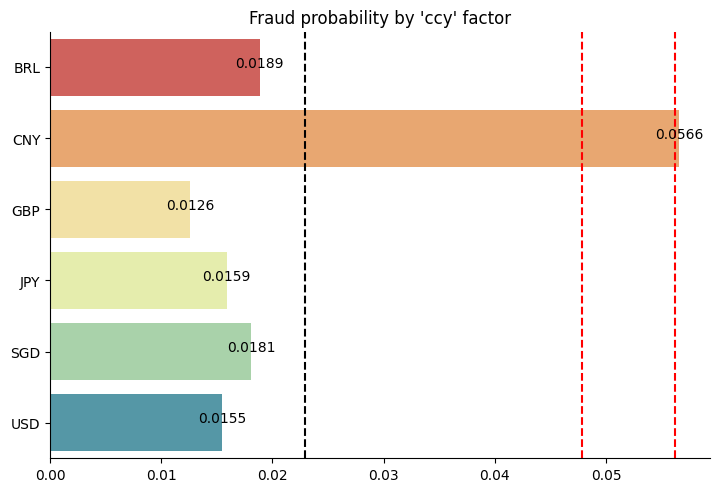

In [13]:
plotDictionary(trxns_data, colname="ccy", quantile_threshold=0.9, count_filter=5)

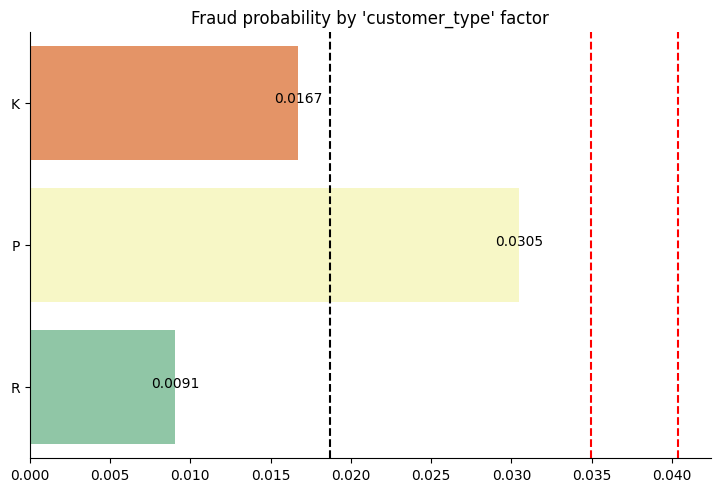

In [20]:
plotDictionary(trxns_data, colname="customer_type", quantile_threshold=0.9, count_filter=5)

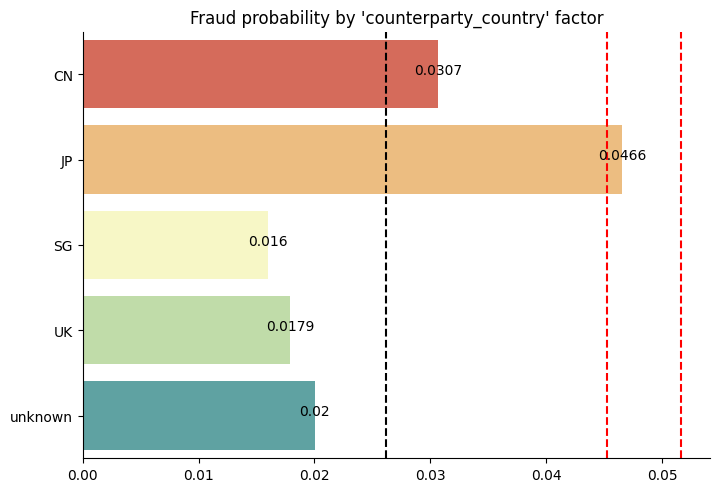

In [21]:
plotDictionary(trxns_data, colname="counterparty_country", quantile_threshold=0.9, count_filter=5)

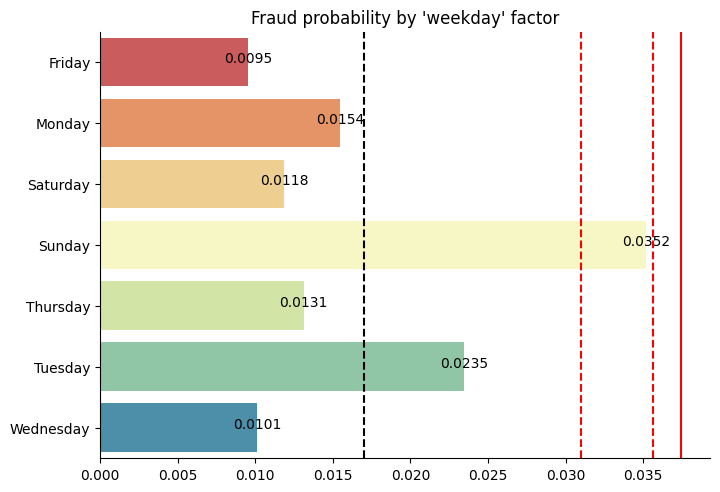

In [22]:
plotDictionary(trxns_data, colname="weekday", quantile_threshold=0.9, count_filter=5)

### ANOVA f-test

With one-hot encoding get all the factors from the variables as separate variables and analyze their association with the fraud flag.

1. Select the features
2. Split the data into features (X) and target (y)
3. Perform one-hot encoding
4. Define the number of top features to select
5. Perform univariate feature selection using ANOVA F-value
6. Get the scores and p-values of each feature
7. Create a DataFrame to store the results
8. Filter out the features with pvalue less or equal to 0.01

In [23]:
feature_names = [
    "customer_country",
    "counterparty_country",
    "type",
    "ccy",
    "customer_type",
    "weekday",
    "month",
    "quarter",
    "hour",
    "amount_eur_bucket",
]

X = trxns_data[feature_names]
y = trxns_data["fraud_flag"]

X_encoded = pd.get_dummies(X, columns=feature_names)

k = 50

selector = SelectKBest(f_classif, k=k)
selector.fit(X_encoded, y)

scores = selector.scores_
pvalues = selector.pvalues_

results_df = pd.DataFrame(
    {"feature": X_encoded.columns, "score": scores, "pvalue": pvalues}
)
results_df = results_df.sort_values(by="score", ascending=False)

results_df = results_df[results_df["pvalue"] <= 0.01]
print(results_df.head(k))

                                    feature      score        pvalue
21                             type_PAYMENT  73.624405  1.225702e-17
25                                  ccy_CNY  38.885269  4.842681e-10
9                   counterparty_country_JP  30.765566  3.052713e-08
35                          customer_type_P  30.489511  3.516585e-08
73                                  hour_13  19.631395  9.580562e-06
40                           weekday_Sunday  17.347717  3.162185e-05
53                           month_November  13.523695  2.379037e-04
86  amount_eur_bucket_(43377.466, 62376.65]  12.190181  4.843339e-04
33                          customer_type_C  11.684473  6.349856e-04
51                              month_March  10.310940  1.330337e-03
63                                   hour_3   9.560922  1.997962e-03
18                            type_INTEREST   9.044535  2.647180e-03
16                             type_BILLING   8.011065  4.666738e-03
17                            type